# Tully-Fisher Relation of galaxies

For all galaxies in Iron (Y1) which have valid rotational velocities at $0.4R_{26}$, plot their TFR.  Also include the best-fit TFR (as calibrated using `TF_Y1_cluster_calibration_KAD.ipynb`).

In [1]:
from astropy.table import Table
from astropy import cosmology
from astropy.io import fits
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

import numpy as np

import pickle

import matplotlib.pyplot as plt

# Custom functions / classes
import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
h = 0.7762 # From TF_iron-jointTFR-varyV0-perpdwarfs_H0.ipynb
# h = 0.7019 # From TF_iron-jointTFR-varyV0-perpdwarfs_H0.ipynb, with only primary SN matches
H0 = 100*h

c = const.c.to('km/s')

q0 = 0.2

# Data

In [3]:
# SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_VI.fits')
SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_VI_photsys.fits')
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06,122.32238811543634,2.5088414493427758,N
55,SGA-2020 55,PGC120394

## Photometric corrections

### Survey offsets

In [4]:
sys_corr, sys_corr_err = BASS_corr(SGA_TF['PHOTSYS'])

### MW Dust corrections

In [5]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [6]:
MWdust_corr, MWdust_corr_err = MW_dust(SGA_TF['RA'], SGA_TF['DEC'], ebv_map)

/global/u1/k/kadglass/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [7]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [8]:
# Apparently we have some galaxies with negative redshifts
zg0 = SGA_TF['Z_DESI'] >= 0

In [9]:
kcorr_zg0 = k_corr(SGA_TF['Z_DESI'][zg0], 
                   [SGA_TF['G_MAG_SB26'][zg0], SGA_TF['R_MAG_SB26'][zg0], SGA_TF['Z_MAG_SB26'][zg0]], 
                   [SGA_TF['G_MAG_SB26_ERR'][zg0], SGA_TF['R_MAG_SB26_ERR'][zg0], SGA_TF['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # to match FastSpecFit / FP

In [10]:
kcorr = np.zeros([len(SGA_TF), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [11]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [12]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)

internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [13]:
internalDust_corr, internalDust_corr_err = internal_dust(SGA_TF['BA'], 
                                                         internalDust_coeffs, 
                                                         internalDust_coeffs_err)

### Apply corrections

In [14]:
SGA_TF['R_MAG_SB26_CORR'] = SGA_TF['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr

In [15]:
SGA_TF['R_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err**2)

# TFR

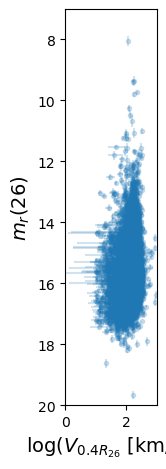

In [16]:
plt.figure(tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p4R26']), 
             SGA_TF['R_MAG_SB26_CORR'], 
             xerr=0.434*SGA_TF['V_0p4R26_err']/SGA_TF['V_0p4R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR_CORR'], 
             fmt='.', 
             alpha=0.2)

# plt.errorbar(np.log10(SGA_TF_corr['V_0p4R26']), 
#              SGA_TF_corr['R_MAG_SB26_CORR'], 
#              xerr=0.434*SGA_TF_corr['V_0p4R26_err']/SGA_TF_corr['V_0p4R26'],
#              yerr=SGA_TF_corr['R_MAG_SB26_CORR_ERR'], 
#              fmt='.', 
#              ecolor='bisque',
#              alpha=0.5)

plt.xlim([0, 3])
plt.ylim([20, 7])

plt.xlabel('log($V_{0.4R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$m_r (26)$', fontsize=14)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box');

## Compute the absolute magnitudes based on the redshift

In [17]:
'''
d = c*SGA_TF['Z_DESI']/H0*1e6 # pc
d_err = c*SGA_TF['ZERR_DESI']/H0*1e6 # pc

SGA_TF['R_ABSMAG_SB26'] = SGA_TF['R_MAG_SB26'] - 5*np.log10((d/10.).data)
SGA_TF['R_ABSMAG_SB26_err'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + (5/np.log(10))**2 * ((d_err/d)**2).data)
'''
cosmo = cosmology.FlatLambdaCDM(H0=H0*u.km/(u.s*u.Mpc), Om0=0.30966) # Planck's value of Omega_M0
mu = cosmo.distmod(SGA_TF['Z_DESI'])

SGA_TF['R_ABSMAG_SB26'] = SGA_TF['R_MAG_SB26_CORR'] - mu.value

In [18]:
rng = np.random.default_rng()

N_samples = 1000

mu_err = np.empty(len(mu))*u.mag

for i in range(len(mu_err)):
    
    z_desi_random = rng.normal(np.abs(SGA_TF['Z_DESI'][i]), 
                               SGA_TF['ZERR_DESI'][i], 
                               N_samples)
    
    mu_random = cosmo.distmod(z_desi_random)
    # TO DO: Take into account H0 uncertainty
    
    mu_err[i] = np.std(mu_random)
    
SGA_TF['R_ABSMAG_SB26_err'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + mu_err.value**2)

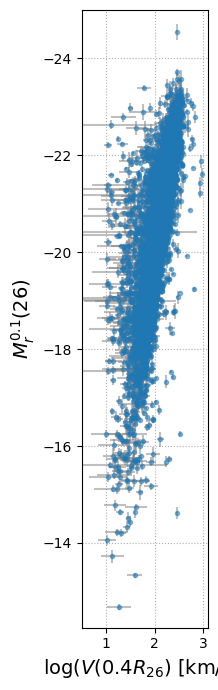

In [19]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

plt.errorbar(np.log10(SGA_TF['V_0p4R26']), 
             SGA_TF['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p4R26_err']/SGA_TF['V_0p4R26'],
             yerr=SGA_TF['R_ABSMAG_SB26_err'], 
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

# plt.errorbar(np.log10(SGA_TF_corr['V_0p4R26']), 
#              SGA_TF_corr['R_ABSMAG_SB26_CORR'], 
#              xerr=0.434*SGA_TF_corr['V_0p4R26_err']/SGA_TF_corr['V_0p4R26'],
#              yerr=SGA_TF_corr['R_ABSMAG_SB26_CORR_err'], 
#              fmt='.', 
#              alpha=0.5, 
#              ecolor='bisque')

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -25])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26)$', fontsize=14)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box');

## Plotted with our TFR

In [20]:
logv = np.linspace(-1, 3.5, 100)

### Calibration without dwarfs

Here, $V_0$, the slope, and the y-intercept are from `TF_Y1_cluster_calibration_KAD.ipynb`:

\begin{equation}
  M_r = a (\log(V(0.4R_{26})) - V_0) + b
\end{equation}

where
* $V_0 = 2.17$
* $a = -6.34 \pm 0.07$
* $b = -21.08^{+0.03}_{-0.02}$

*(Updated 12/20/24)*

In [21]:
# temp_infile = open('cov_ab_iron_jointTFR_varyV0-perpdwarfs_KAD.pickle', 'rb')
temp_infile = open('cov_ab_iron_jointTFR_varyV0-perpdwarfs0_z0p1_binaryMLupdated_KAD-20241220.pickle', 'rb')
# temp_infile = open('cov_ab_iron_jointTFR_varyV0-perpdwarfs0_binaryMLupdated_primarySNonly_KAD-20241210.pickle', 'rb')
cov_ab, tfr_samples, V0 = pickle.load(temp_infile)
temp_infile.close()

In [22]:
slope = np.median(tfr_samples[0])
slope_err = np.sqrt(cov_ab[0,0])

ZP = np.median(tfr_samples[1])
ZP_err = np.sqrt(cov_ab[1,1])

absmag = slope*(logv - V0) + ZP

In [23]:
# Calculate the uncertainties in the calibrated TFR
slopes = tfr_samples[0]
ZPs = tfr_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - V0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)

In [24]:
logV_n17 = (-17 - ZP)/slope + V0
b_perp = -17 + (1/slope)*(logV_n17 - V0)

dwarf_boolean = (SGA_TF['R_ABSMAG_SB26'] - SGA_TF['R_ABSMAG_SB26_err']) > (-(np.log10(SGA_TF['V_0p4R26']) - V0)/slope + b_perp)
# dwarf_boolean_corr = (SGA_TF_corr['R_ABSMAG_SB26_CORR'] - SGA_TF_corr['R_ABSMAG_SB26_CORR_err']) > (-(np.log10(SGA_TF_corr['V_0p4R26']) - V0)/slope + b_perp)

print(10**(logV_n17), 'km/s')

33.79755090327593 km/s


In [25]:
print(sum(dwarf_boolean), 'dwarfs')
print(len(SGA_TF) - sum(dwarf_boolean), 'non-dwarfs')

# print(sum(dwarf_boolean_corr), 'dwarfs')
# print(len(SGA_TF_corr) - sum(dwarf_boolean_corr), 'non-dwarfs')

123 dwarfs
10140 non-dwarfs


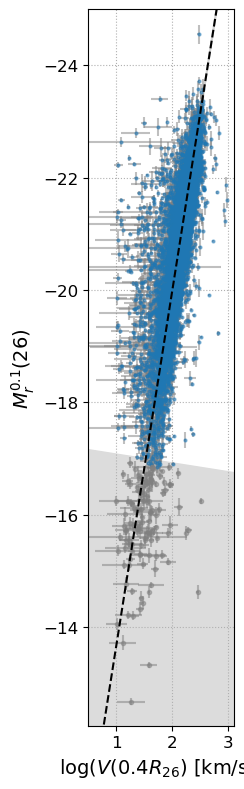

In [26]:
yvals_perp = -(logv - V0)/slope + b_perp

plt.figure(figsize=(4,8), tight_layout=True)

plt.grid(ls=':')

plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

plt.errorbar(np.log10(SGA_TF['V_0p4R26'][~dwarf_boolean]), 
             SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean], 
             xerr=0.434*SGA_TF['V_0p4R26_err'][~dwarf_boolean]/SGA_TF['V_0p4R26'][~dwarf_boolean],
             yerr=SGA_TF['R_ABSMAG_SB26_err'][~dwarf_boolean], 
             fmt='.', 
             # color='tab:orange',
             markersize=4, 
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][dwarf_boolean]), 
             SGA_TF['R_ABSMAG_SB26'][dwarf_boolean], 
             xerr=0.434*SGA_TF['V_0p4R26_err'][dwarf_boolean]/SGA_TF['V_0p4R26'][dwarf_boolean],
             yerr=SGA_TF['R_ABSMAG_SB26_err'][dwarf_boolean], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')

plt.plot(logv, absmag, 'k--', zorder=3)

# plt.plot(logv, yvals_perp, 'r:')
plt.fill_between(logv, yvals_perp, -12, color='gainsboro')

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -25])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26)$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_aspect('equal', adjustable='box');

plt.savefig('../../Figures/Y1/iron_jointTFR_varyV0-perpdwarf_z0p1_20241220.png', dpi=150, facecolor='none');

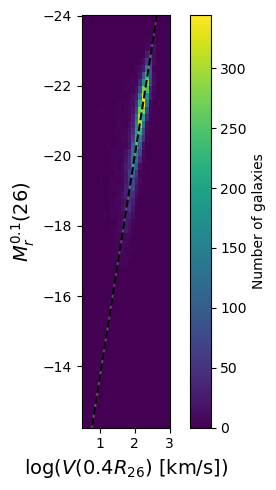

In [27]:
plt.figure(figsize=(4.5,5), tight_layout=True)

plt.hist2d(np.log10(SGA_TF['V_0p4R26'][~dwarf_boolean]), 
           SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean], 
           bins=[np.arange(0.5,3.1,0.1), np.arange(-24, -11.9, 0.2)])
plt.colorbar(label='Number of galaxies')

plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([0.5, 3])
plt.ylim([-12.25, -24])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26)$', fontsize=14);

ax = plt.gca()
ax.set_aspect('equal', adjustable='box');

#### Redshift distribution

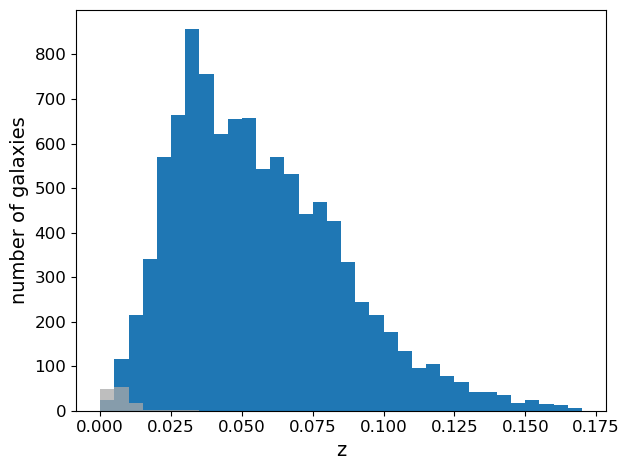

In [28]:
plt.figure(tight_layout=True)

plt.hist(SGA_TF['Z_DESI'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
plt.hist(SGA_TF['Z_DESI'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray', alpha=0.75)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('z', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

# plt.savefig('../../Figures/Y1/iron_z_hist_20240808.png', dpi=150, facecolor='none');

# Distance moduli

In [29]:
SGA_TF['R_ABSMAG_SB26_TF'] = slope*(np.log10(SGA_TF['V_0p4R26']) - V0) + ZP

In [30]:
SGA_TF['R_ABSMAG_SB26_TF_err'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(SGA_TF))):
    
    v_random = rng.normal(SGA_TF['V_0p4R26'][i], SGA_TF['V_0p4R26_err'][i], size=len(slopes))
    
    Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    
    SGA_TF['R_ABSMAG_SB26_TF_err'][i] = np.nanstd(Ms)

100%|██████████| 10263/10263 [03:39<00:00, 46.74it/s]


## Compute distance modulus based on our TFR

In [31]:
SGA_TF['mu_TF'] = SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['R_ABSMAG_SB26_TF']

SGA_TF['mu_TF_err'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['R_ABSMAG_SB26_TF_err']**2)

## $\Delta M_r$ v. redshift

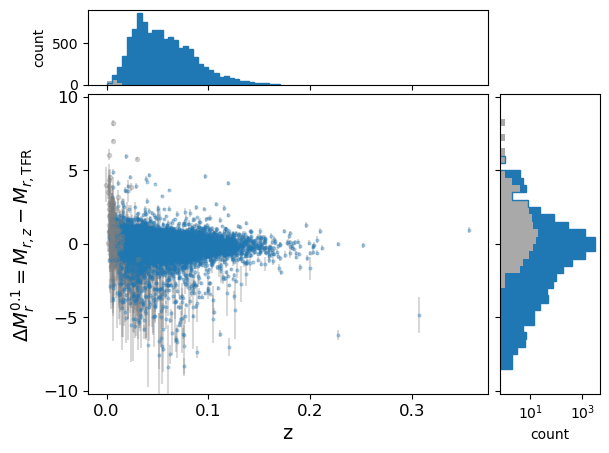

In [32]:
fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax.errorbar(SGA_TF['Z_DESI'][~dwarf_boolean], 
             SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TF'][~dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
             yerr=SGA_TF['mu_TF_err'][~dwarf_boolean],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI'][dwarf_boolean], 
             SGA_TF['R_ABSMAG_SB26'][dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TF'][dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
             yerr=SGA_TF['mu_TF_err'][dwarf_boolean],
             fmt='.', 
             color='gray',
             alpha=0.3, 
             ecolor='gray')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('z', fontsize=14)
ax.set_ylabel(r'$\Delta M_r^{0.1} = M_{r, z} - M_{r, \text{TFR}}$', fontsize=14)

ax.set_ylim((-10.2, 10.2))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='tab:blue', histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TF'][~dwarf_boolean], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TF'][dwarf_boolean], 
              bins=np.arange(-12.5, 10, 0.5), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TF'][~dwarf_boolean], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

plt.savefig('../../Figures/Y1/iron_deltaM-v-z_jointTFR-varyV0-perpdwarfs_z0p1_20241220.png', 
            dpi=150, 
            facecolor='none', 
            bbox_inches='tight');

### Hubble diagram

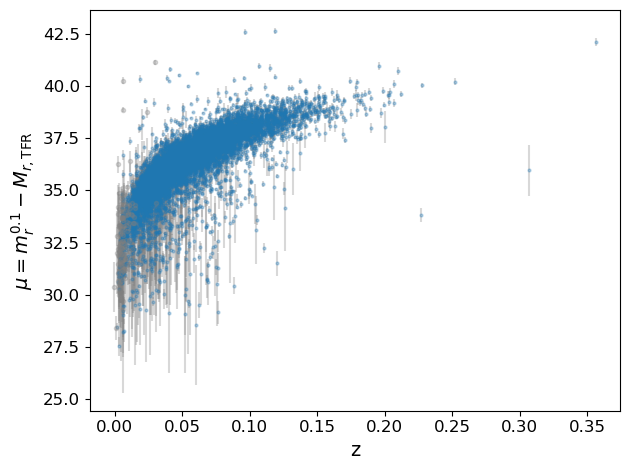

In [33]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_TF['Z_DESI'][~dwarf_boolean], 
             SGA_TF['mu_TF'][~dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
             yerr=SGA_TF['mu_TF_err'][~dwarf_boolean],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')
plt.errorbar(SGA_TF['Z_DESI'][dwarf_boolean], 
             SGA_TF['mu_TF'][dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
             yerr=SGA_TF['mu_TF_err'][dwarf_boolean],
             fmt='.', 
             color='gray',
             alpha=0.3, 
             ecolor='gray')

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('z', fontsize=14)
plt.ylabel(r'$\mu = m_r^{0.1} - M_{r, \text{TFR}}$', fontsize=14);

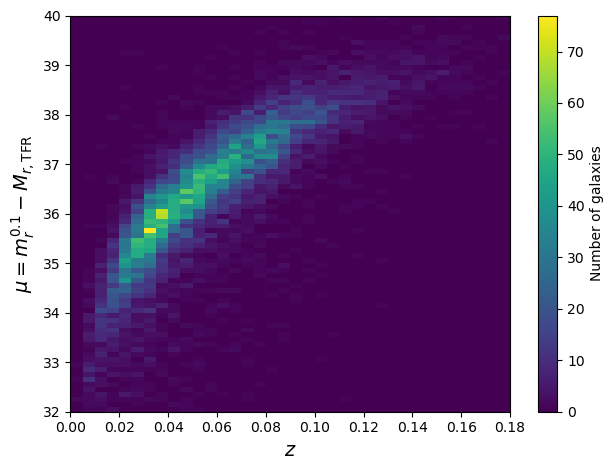

In [34]:
plt.figure(tight_layout=True)

plt.hist2d(SGA_TF['Z_DESI'][~dwarf_boolean], 
           SGA_TF['mu_TF'][~dwarf_boolean], 
           bins=[np.arange(0,0.35,0.005), np.arange(25, 43, 0.1)])
plt.colorbar(label='Number of galaxies')

plt.xlim([0, 0.18])
plt.ylim([32, 40])

plt.xlabel('$z$', fontsize=14)
plt.ylabel(r'$\mu = m_r^{0.1} - M_{r, \text{TFR}}$', fontsize=14);

## Save distance moduli to a file

In [35]:
hdr = fits.Header()

hdr['DESI_DR'] = 'DR1'
hdr['V_RADIUS'] = '0.4 R26'
hdr['M'] = slope
hdr['M_ERR'] = slope_err
hdr['0PT'] = ZP
hdr['0PT_ERR'] = ZP_err
hdr['V0'] = V0
hdr['SIG'] = np.median(tfr_samples[-1])
hdr['SIG_ERR'] = np.sqrt(cov_ab[-1,-1])

empty_primary = fits.PrimaryHDU(header=hdr)

In [36]:
table_hdu = fits.BinTableHDU(data=SGA_TF)

hdul = fits.HDUList([empty_primary, table_hdu])

# Write results to file
hdul.writeto('SGA_iron_jointTFR-varyV0-perpdwarf-fitH0_z0p1_moduli.fits', overwrite=True)